# use literature + pharmaproject



In [64]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd 
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


def harmonic_sum(data, scale_factor=1, cap=None):
    """
    Returns an harmonic sum for the data passed
    Args:
        data (list): list of floats to compute the harmonic sum from
        scale_factor (float): a scaling factor to multiply to each datapoint. Defaults to 1
        cap (float): if not None, never return an harmonic sum higher than the cap value.
    Returns:
        harmonic_sum (float): the harmonic sum of the data passed
    """
    
    data.sort(reverse=True)
    harmonic_sum = sum(s / ((i+1) ** scale_factor) for i, s in enumerate(data))
    
    # Applying cap:
    if cap is not None and harmonic_sum > cap:
        return cap
      
    return harmonic_sum

def scaling_vectors(array, target_min=0, target_max=1):
    '''
    Linear scaling of an array between two targets
    '''

    array_max = array.max()
    array_min = array.min()

    scaled = []

    for value in array:
        fract = (value - array_min)/(array_max - array_min)
        scaled.append((target_max - target_min)*fract + target_min)

    return np.array(scaled)


In [2]:
##
## EVA Read data:
##
eva_df = pd.read_csv('updated_eva.tsv.gz', compression='infer', sep='\t')
eva = eva_df[['target','disease','star','review_status','clinical_significance','consequence']]
eva.clinical_significance = eva.clinical_significance.apply(lambda x: json.loads(x))


print(f'Number of entries in eva: {len(eva)}')
print(f'Number of disease/target associations pair: {len(eva[["target","disease"]].drop_duplicates())}')

##
## Read PharmaProject data:
##

# Reading pharmaproject file as dataframe:
pharma_df = pd.read_csv('/Users/dsuveges/project/issue-1166_benchmarking_clingen_evidences/abbvie_pharmaprojects_2018_mapped.csv')

# Renaming columns for easy handling:
pharma_df.rename(columns={
    'ensembl_id': 'target',
    'id': 'disease',
    'lApprovedUS.EU': 'approved'
}, inplace=True)

print(f'Number of entries in pharmaproject: {len(pharma_df)}')
print(f'Number of disease/target associations pair: {len(pharma_df[["target","disease"]].drop_duplicates())}')

##
## Read literature data:
##
literature_df = pd.read_parquet('/Users/dsuveges/project/evidences/20.06_evidence_data.filtered.parquet')
literature_df.rename(columns={
    'efo_code': 'disease',
    'gene_id': 'target'
}, inplace=True)

# Applying score threshold:
literature_df = literature_df.loc[literature_df.assoc_score >= 0.6]

print(f'rows: {len(literature_df)}')
print(f'unique associations: {len(literature_df[["disease","target"]].drop_duplicates())}')


summed_data = []
for (target, disease), group in literature_df.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'assoc_score': harmonic_sum(group.assoc_score.tolist())
    }) 

literature_assoc = pd.DataFrame(summed_data)

print(f'rows: {len(literature_assoc)}')
print(f'unique associations: {len(literature_assoc[["disease","target"]].drop_duplicates())}')




/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Number of entries in eva: 574097
Number of disease/target associations pair: 21548
Number of entries in pharmaproject: 22947
Number of disease/target associations pair: 22947
rows: 32570
unique associations: 20289
rows: 20289
unique associations: 20289


In [57]:

##
## Merging EVA and all positive controls together:
##

# Pharmaproject data:
pharma_assoc = pharma_df.copy()
pharma_assoc['approved'] = True

# Literature data:
lit_assoc = literature_df[['target','disease']].drop_duplicates()
lit_assoc['literature_poscon'] = True

# Get overlapping positive controls + EVA associations:
overlap_df = eva_df[['target', 'disease']].drop_duplicates().merge(pharma_assoc, on=['disease','target'], how='left')
overlap_df = overlap_df.merge(lit_assoc, on=['disease','target'], how='left')
overlap_df['positive_control'] = overlap_df.apply(lambda row: True if row['literature_poscon'] == True or row['approved'] == True else False,axis=1)

# Gererate a subset of table + merge with positive controls:
eva = eva_df[['target','disease','star','review_status','clinical_significance','consequence']]
eva.clinical_significance = eva.clinical_significance.apply(lambda x: json.loads(x))
eva = eva.merge(overlap_df[['target','disease','positive_control']], on=['target','disease'], how='left')


/Users/dsuveges/opt/anaconda3/envs/jupyter/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# ROC - variant consequences only.

* For scoring variant consequences we use the old weights. 
* Then association scores are calculated. 
* Then ROC calaculated against all positive controls

In [58]:
eva_consequences_order_map = {'downstream_gene_variant': 0.6,
 'upstream_gene_variant': 0.6,
 'intron_variant': 0.65,
 'non_coding_transcript_exon_variant': 0.65,
 '3_prime_UTR_variant': 0.65,
 '5_prime_UTR_variant': 0.65,
 'mature_miRNA_variant': 0.65,
 'coding_sequence_variant': 0.95,
 'synonymous_variant': 0.65,
 'stop_retained_variant': 0.65,
 'incomplete_terminal_codon_variant': 0.9,
 'splice_region_variant': 0.9,
 'protein_altering_variant': 0.7,
 'missense_variant': 0.7,
 'inframe_deletion': 0.7,
 'inframe_insertion': 0.7,
 'start_lost': 0.95,
 'stop_lost': 0.9,
 'frameshift_variant': 0.95,
 'stop_gained': 0.95,
 'splice_donor_variant': 0.95,
 'splice_acceptor_variant': 0.95,
 'trinucleotide_repeat_expansion': 1,
 'short_tandem_repeat_expansion': 1}

old_evidence_score = eva[['target','disease','consequence','positive_control']].copy()
old_evidence_score['consequence_weight'] = old_evidence_score.consequence.map(eva_consequences_order_map)

##
## Get association score:
##
summed_data = []
for (target, disease), group in old_evidence_score.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'positive_control': group.positive_control.tolist()[0],
        'variant_consequence': harmonic_sum(group.consequence_weight.tolist())
    }) 
    
association_scores = pd.DataFrame(summed_data)
association_scores.head()

,target,disease,positive_control,variant_consequence
0,ENSG00000000419,Orphanet_137,False,3.881014
1,ENSG00000000971,EFO_0001365,True,3.856524
2,ENSG00000000971,EFO_0003884,False,0.950000
3,ENSG00000000971,EFO_1001155,False,3.960965
4,ENSG00000000971,Orphanet_200421,False,2.425278


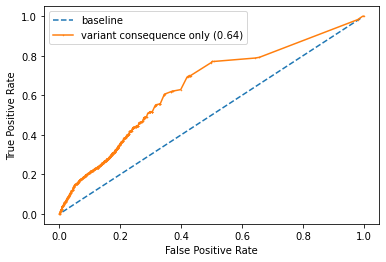

In [59]:
# Variant consequence based scores:
fpr_var, tpr_var, thresholds = roc_curve(association_scores.positive_control, association_scores.variant_consequence)
auc_var = roc_auc_score(association_scores.positive_control, association_scores.variant_consequence)


# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_var, tpr_var, marker='.', markersize = 1, label=f'variant consequence only ({auc_var:.2})') # reference

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

In [60]:

# Get enrichment: 
def get_poscon_enrichment(df, col_header):
    '''
    get enrichment and hit counts.
    '''
    poscon_count = len(df.loc[df.positive_control])
    top_n = df.sort_values([col_header], ascending=False).head(poscon_count)
    hits = len(top_n.loc[top_n.positive_control])
    expected = poscon_count / len(df) * poscon_count
    enrichment = hits / expected 
    return (hits, enrichment)
    
get_poscon_enrichment(association_scores, 'variant_consequence')


(36, 2.8688165680473374)

In [34]:
association_scores.columns

Index(['target', 'disease', 'positive_control', 'variant_consequence'], dtype='object')

# ROC 



In [101]:


eva_consequences_order_map = {
    'downstream_gene_variant': 0.6,
    'upstream_gene_variant': 0.6,
    'intron_variant': 0.65,
    'non_coding_transcript_exon_variant': 0.65,
    '3_prime_UTR_variant': 0.65,
    '5_prime_UTR_variant': 0.65,
    'mature_miRNA_variant': 0.65,
    'coding_sequence_variant': 0.95,
    'synonymous_variant': 0.65,
    'stop_retained_variant': 0.65,
    'incomplete_terminal_codon_variant': 0.9,
    'splice_region_variant': 0.9,
    'protein_altering_variant': 0.7,
    'missense_variant': 0.7,
    'inframe_deletion': 0.7,
    'inframe_insertion': 0.7,
    'start_lost': 0.95,
    'stop_lost': 0.9,
    'frameshift_variant': 0.95,
    'stop_gained': 0.95,
    'splice_donor_variant': 0.95,
    'splice_acceptor_variant': 0.95,
    'trinucleotide_repeat_expansion': 1,
    'short_tandem_repeat_expansion': 1
}

# Review status is an ordinal variable. Mapping to numbers:
review_status_order_map = {
    'no assertion provided': 1/7,
    'no assertion criteria provided': 2/7,
    'criteria provided, conflicting interpretations': 3/7,
    'criteria provided, single submitter': 4/7,
    'criteria provided, multiple submitters, no conflicts': 5/7,
    'reviewed by expert panel': 6/7,
    'practice guideline': 7/7
}

clinical_significance_mapping = {
    'association not found': 0    
    'benign': 0,
    'not provided': 0,
    'uncertain significance': 0,    
    'likely benign': 0.2,    
    'conflicting interpretations of pathogenicity': 0.3,   
    'other': 0.3,
    'association': 0.5,
    'drug response': 0.5,
    'protective':0.5,
    'affects': 0.7,
    'likely pathogenic' : 0.8,
    'risk factor': 0.8,
    'pathogenic' : 1,
}

simplified_evid = eva[['target','disease','consequence','positive_control','review_status']].copy()
simplified_evid['consequence_weighted'] = simplified.consequence.map(eva_consequences_order_map)
simplified_evid['review_weighted'] = simplified.review_status.map(review_status_order_map)

##
## Run estimator:
##
print('Running estimator...')
rf = RandomForestClassifier()
columns = ['consequence_weighted','review_weighted']
rf.fit(simplified_evid[columns],simplified_evid.positive_control)    

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)

##
## Scaling review status 
##
print('Scaling reivew status')    
simplified_evid['simplified_review_weighted'] = weight_series['review_weighted'] * simplified_evid['review_weighted']

##
## Scaling variant consequences:
##
print('Scaling variant consequences...')
simplified_evid['simplified_consequence_weighted'] = weight_series['consequence_weighted'] * simplified_evid['consequence_weighted']



Running estimator...
Extract weights...
consequence_weighted    0.267255
review_weighted         0.732745
dtype: float64
Scaling reivew status
Scaling variant consequences...
Combining scores
            target          disease  positive_control  simplified  rev_stat
0  ENSG00000000419     Orphanet_137             False    0.461025  2.809237
1  ENSG00000000971      EFO_0001365              True    0.427189  2.719519
2  ENSG00000000971      EFO_0003884             False    0.105531  0.571429
3  ENSG00000000971      EFO_1001155             False    0.432297  2.938070
4  ENSG00000000971  Orphanet_200421             False    0.216400  1.360658
(36, 2.8688165680473374)
(34, 2.7094378698224855)
(36, 2.8688165680473374)


In [126]:


##
## Scaling review status 
##
print('Scaling reivew status')    
simplified_evid['simplified_review_weighted'] = weight_series['review_weighted'] * 1 # simplified_evid['review_weighted']

##
## Scaling variant consequences:
##
print('Scaling variant consequences...')
simplified_evid['simplified_consequence_weighted'] = weight_series['consequence_weighted'] * 1 # simplified_evid['consequence_weighted']



##
## Combine all weights and scale:
##
print('Combining scores')    
simplified_evid['simplified'] = simplified_consequence_weighted + simplified_review_weighted


##
## Scaling clinical significance:
##
simplified_evid['clinical_significance_weighted'] = eva.clinical_significance.apply(lambda y: max([x for x in map(lambda x: clinical_significance_mapping[x], y)]))

##
## Get association score:
##
summed_data = []
for (target, disease), group in simplified_evid.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'positive_control': group.positive_control.tolist()[0],
        'simplified': harmonic_sum(group.simplified.tolist()),
        'rev_stat': harmonic_sum(group.review_weighted.tolist()),
        'clin_sig': harmonic_sum(group.clinical_significance_weighted.tolist())
    }) 
    
simplified_assoc = pd.DataFrame(summed_data)    
print(simplified_assoc.head())
print(get_poscon_enrichment(association_scores, 'variant_consequence'))
print(get_poscon_enrichment(simplified_assoc, 'simplified'))
print(get_poscon_enrichment(simplified_assoc, 'rev_stat'))
print(get_poscon_enrichment(simplified_assoc, 'clin_sig'))


Scaling reivew status
Scaling variant consequences...
Combining scores
            target          disease  positive_control  simplified  rev_stat  \
0  ENSG00000000419     Orphanet_137             False    3.061347  2.809237   
1  ENSG00000000971      EFO_0001365              True    3.019755  2.719519   
2  ENSG00000000971      EFO_0003884             False    0.671447  0.571429   
3  ENSG00000000971      EFO_1001155             False    3.117236  2.938070   
4  ENSG00000000971  Orphanet_200421             False    1.625418  1.360658   

   clin_sig  
0  2.774043  
1  1.976146  
2  0.800000  
3  2.221858  
4  2.717857  
(36, 2.8688165680473374)
(36, 2.8688165680473374)
(36, 2.8688165680473374)
(56, 4.462603550295858)


(36, 2.8688165680473374)


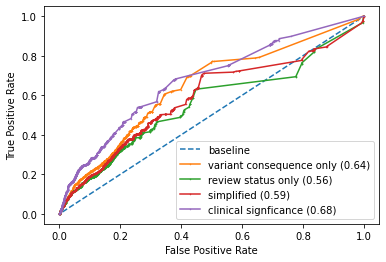

In [127]:
print(get_poscon_enrichment(simplified_assoc, 'simplified'))

# Variant consequence based scores:
fpr_var, tpr_var, thresholds = roc_curve(association_scores.positive_control, association_scores.variant_consequence)

# Scores based on reiview status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.rev_stat)
auc_rev = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.rev_stat)

# Scores based on variant consequences + review status:
fpr_sim, tpr_sim, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.simplified)
auc_sim = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.simplified)

# Scores based on clinical significance:
fpr_clin, tpr_clin, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.clin_sig)
auc_clin = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.clin_sig)



# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_var, tpr_var, marker='.', markersize = 1, label=f'variant consequence only ({auc_var:.2})') # reference
pyplot.plot(fpr_rev, tpr_rev, marker='.', markersize = 1, label=f'review status only ({auc_rev:.2})') # reference
pyplot.plot(fpr_sim, tpr_sim, marker='.', markersize = 1, label=f'simplified ({auc_sim:.2})') # reference
pyplot.plot(fpr_clin, tpr_clin, marker='.', markersize = 1, label=f'clinical signficance ({auc_clin:.2})') # reference


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()


In [108]:
eva.clinical_significance.apply(lambda x: x[0] if len(x) > 1 else None).unique().tolist()

[None,
 'likely pathogenic',
 'pathogenic',
 'benign',
 'affects',
 'other',
 'risk factor',
 'conflicting interpretations of pathogenicity',
 'likely benign',
 'association']

## clinical significance + review status + consequence

In [134]:
columns = ['consequence_weighted','review_weighted', 'clinical_significance_weighted']
rf.fit(simplified_evid[columns],simplified_evid.positive_control)    

# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)




Extract weights...
consequence_weighted              0.165398
review_weighted                   0.329977
clinical_significance_weighted    0.504626
dtype: float64


In [139]:
def calculate_score(row):
    score = 0
    for col in columns:
        score += weight_series[col] * row[col]
        
    return(score)

simplified_evid['combined_score'] = simplified_evid.apply(calculate_score, axis=1)


summed_data = []
for (target, disease), group in simplified_evid.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'positive_control': group.positive_control.tolist()[0],
        'simplified': harmonic_sum(group.simplified.tolist()),
        'rev_stat': harmonic_sum(group.review_weighted.tolist()),
        'clin_sig': harmonic_sum(group.clinical_significance_weighted.tolist()),
        'combined_score': harmonic_sum(group.combined_score.tolist()),
    }) 
    
simplified_assoc = pd.DataFrame(summed_data)    
print(simplified_assoc.head())
print(get_poscon_enrichment(association_scores, 'variant_consequence'))
print(get_poscon_enrichment(simplified_assoc, 'simplified'))
print(get_poscon_enrichment(simplified_assoc, 'rev_stat'))
print(get_poscon_enrichment(simplified_assoc, 'clin_sig'))
print(get_poscon_enrichment(simplified_assoc, 'combined_score'))

            target          disease  positive_control  simplified  rev_stat  \
0  ENSG00000000419     Orphanet_137             False    3.061347  2.809237   
1  ENSG00000000971      EFO_0001365              True    3.019755  2.719519   
2  ENSG00000000971      EFO_0003884             False    0.671447  0.571429   
3  ENSG00000000971      EFO_1001155             False    3.117236  2.938070   
4  ENSG00000000971  Orphanet_200421             False    1.625418  1.360658   

   clin_sig  combined_score  
0  2.774043        2.814928  
1  1.976146        2.374554  
2  0.800000        0.749386  
3  2.221858        2.481634  
4  2.717857        2.162958  
(36, 2.8688165680473374)
(36, 2.8688165680473374)
(36, 2.8688165680473374)
(56, 4.462603550295858)
(46, 3.6657100591715976)


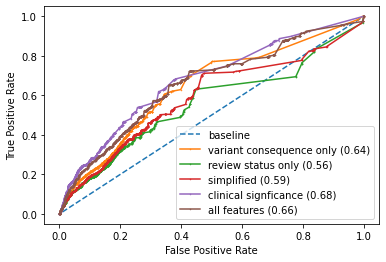

In [140]:
# Variant consequence based scores:
fpr_var, tpr_var, thresholds = roc_curve(association_scores.positive_control, association_scores.variant_consequence)

# Scores based on reiview status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.rev_stat)
auc_rev = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.rev_stat)

# Scores based on variant consequences + review status:
fpr_sim, tpr_sim, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.simplified)
auc_sim = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.simplified)

# Scores based on clinical significance:
fpr_clin, tpr_clin, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.clin_sig)
auc_clin = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.clin_sig)

# Combined scores based on all features:
fpr_com, tpr_com, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.combined_score)
auc_com = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.combined_score)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_var, tpr_var, marker='.', markersize = 1, label=f'variant consequence only ({auc_var:.2})') # reference
pyplot.plot(fpr_rev, tpr_rev, marker='.', markersize = 1, label=f'review status only ({auc_rev:.2})') # reference
pyplot.plot(fpr_sim, tpr_sim, marker='.', markersize = 1, label=f'simplified ({auc_sim:.2})') # reference
pyplot.plot(fpr_clin, tpr_clin, marker='.', markersize = 1, label=f'clinical signficance ({auc_clin:.2})') # reference
pyplot.plot(fpr_com, tpr_com, marker='.', markersize = 1, label=f'all features ({auc_com:.2})') # reference

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

# Categorcal clinical significance

In [153]:
# Get unique clinical significance values:
clin_sig = eva[['target','disease','positive_control','clinical_significance']].copy()
clin_sig['clinical_signif'] = clin_sig.clinical_significance.apply(lambda x: x[0] if len(x) == 1 else None)

# Generate dummy features from clinical significance values:
clin_sig = pd.get_dummies(clin_sig, prefix='clin_sig', columns=['clinical_signif'])

# Update dummy columns were more then one clinical significance value is available:
for i, row in clin_sig.loc[clin_sig.clinical_significance.apply(lambda x: True if len(x)>1 else False)].iterrows():
    for sig_val in row['clinical_significance']:
        clin_sig.loc[i,f'clin_sig_{sig_val}'] = 1
        
        
clin_sig.loc[clin_sig.clinical_significance.apply(lambda x: True if len(x)>1 else False)].head()

,target,disease,positive_control,clinical_significance,clin_sig_affects,clin_sig_association,clin_sig_association not found,clin_sig_benign,clin_sig_conflicting interpretations of pathogenicity,clin_sig_drug response,clin_sig_likely benign,clin_sig_likely pathogenic,clin_sig_not provided,clin_sig_other,clin_sig_pathogenic,clin_sig_protective,clin_sig_risk factor,clin_sig_uncertain significance
1236,ENSG00000119899,Orphanet_309334,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
3046,ENSG00000026103,Orphanet_3261,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
3886,ENSG00000136160,Orphanet_897,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
4137,ENSG00000137700,Orphanet_79259,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0
4153,ENSG00000137700,Orphanet_79259,False,"[likely pathogenic, pathogenic]",0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [154]:
rf = RandomForestClassifier()
columns = [x for x in clin_sig.columns if 'clin_sig_' in x]
rf.fit(clin_sig[columns],clin_sig.positive_control)  

RandomForestClassifier()

In [155]:
# Extracting weight:
print('Extract weights...')
weight_series = pd.Series(rf.feature_importances_, index=columns)
print(weight_series)

Extract weights...
clin_sig_affects                                         0.001758
clin_sig_association                                     0.000556
clin_sig_association not found                           0.000039
clin_sig_benign                                          0.089109
clin_sig_conflicting interpretations of pathogenicity    0.006099
clin_sig_drug response                                   0.002320
clin_sig_likely benign                                   0.034340
clin_sig_likely pathogenic                               0.671123
clin_sig_not provided                                    0.003051
clin_sig_other                                           0.028692
clin_sig_pathogenic                                      0.067636
clin_sig_protective                                      0.006018
clin_sig_risk factor                                     0.022178
clin_sig_uncertain significance                          0.067081
dtype: float64


In [156]:
def calculate_score(row):
    score = 0
    for col in columns:
        score += weight_series[col] * row[col]
        
    return(score)

clin_sig['combined_score'] = clin_sig[columns].apply(calculate_score, axis=1)
clin_sig.combined_score

0         0.067636
1         0.067636
2         0.003051
3         0.003051
4         0.003051
            ...   
574092    0.067636
574093    0.089109
574094    0.067081
574095    0.671123
574096    0.067636
Name: combined_score, Length: 574097, dtype: float64

In [158]:
summed_data = []
for (target, disease), group in clin_sig.groupby(['target', 'disease']):
    summed_data.append({
        'target': target,
        'disease': disease,
        'positive_control': group.positive_control.tolist()[0],
        'clin_sig_score': harmonic_sum(group.combined_score.tolist()),
    }) 
    
clin_sig_assoc = pd.DataFrame(summed_data)    
print(clin_sig_assoc.head())
print(get_poscon_enrichment(clin_sig_assoc, 'clin_sig_score'))

            target          disease  positive_control  clin_sig_score
0  ENSG00000000419     Orphanet_137             False        0.328024
1  ENSG00000000971      EFO_0001365              True        0.398059
2  ENSG00000000971      EFO_0003884             False        0.671123
3  ENSG00000000971      EFO_1001155             False        0.387301
4  ENSG00000000971  Orphanet_200421             False        0.197987
(54, 4.303224852071006)


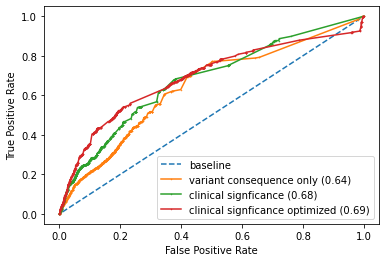

In [160]:
# Variant consequence based scores:
fpr_var, tpr_var, thresholds = roc_curve(association_scores.positive_control, association_scores.variant_consequence)

# Scores based on reiview status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.rev_stat)
auc_rev = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.rev_stat)

# Scores based on clinical significance:
fpr_clin, tpr_clin, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.clin_sig)
auc_clin = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.clin_sig)

# Combined scores based on all improved clinical signif:
fpr_com, tpr_com, thresholds = roc_curve(clin_sig_assoc.positive_control, clin_sig_assoc.clin_sig_score)
auc_com = roc_auc_score(clin_sig_assoc.positive_control, clin_sig_assoc.clin_sig_score)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_var, tpr_var, marker='.', markersize = 1, label=f'variant consequence only ({auc_var:.2})') # reference
pyplot.plot(fpr_clin, tpr_clin, marker='.', markersize = 1, label=f'clinical signficance ({auc_clin:.2})') # reference
pyplot.plot(fpr_com, tpr_com, marker='.', markersize = 1, label=f'clinical signficance optimized ({auc_com:.2})') # reference

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

# Combining evidence


In the following section we pull evidence together and came upwith something

In [208]:
summary = []
for (disease,target), group in simplified_evid.groupby(['disease','target']):
    summary.append({
        'disease': disease,
        'target': target,
        'flag': group.positive_control.to_list()[0],
        'len': len(group),
        'positive_control': group.positive_control.to_list()[0],
        'max_consequence': group.consequence_weighted.max(),
        'max_review': group.review_weighted.max(),
        'max_clin_sig': group.clinical_significance_weighted.max(),
        'mean_consequence': group.consequence_weighted.mean(),
        'mean_review': group.review_weighted.mean(),
        'mean_clin_sig': group.clinical_significance_weighted.mean(),
    })
    
    
assoc_summary = pd.DataFrame(summary)
assoc_summary.head()

,disease,target,flag,len,positive_control,max_consequence,max_review,max_clin_sig,mean_consequence,mean_review,mean_clin_sig
0,EFO_0000095,ENSG00000010671,True,1,True,0.7,0.142857,0.0,0.7,0.142857,0.0
1,EFO_0000095,ENSG00000082898,True,3,True,0.7,0.285714,0.8,0.7,0.285714,0.8
2,EFO_0000095,ENSG00000087365,False,2,False,0.7,0.285714,0.8,0.7,0.285714,0.8
3,EFO_0000095,ENSG00000109670,False,10,False,0.7,0.285714,0.8,0.7,0.285714,0.8
4,EFO_0000095,ENSG00000115524,True,6,True,0.7,0.285714,0.8,0.7,0.285714,0.8


In [179]:
for feature in ['consequence','review','clin_sig']:
    for stat in ['max', 'mean']:
        for value in [True, False]:
            x = assoc_summary.loc[assoc_summary.flag == value, f'{stat}_{feature}'].mean()
            print (f'{value} {stat}_{feature}: {x}')

True max_consequence: 0.8016346153846152
False max_consequence: 0.817146186037664
True mean_consequence: 0.7280341700448539
False mean_consequence: 0.7610190363997776
True max_review: 0.4467032967032966
False max_review: 0.5099527161064159
True mean_review: 0.39085908966756083
False mean_review: 0.4795598971767369
True max_clin_sig: 0.7973076923076924
False max_clin_sig: 0.6658978504850676
True mean_clin_sig: 0.5686533625696805
False mean_clin_sig: 0.4955421417864254


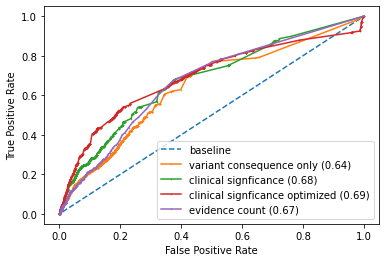

In [212]:
# Variant consequence based scores:
fpr_var, tpr_var, thresholds = roc_curve(association_scores.positive_control, association_scores.variant_consequence)

# Scores based on reiview status:
fpr_rev, tpr_rev, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.rev_stat)
auc_rev = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.rev_stat)

# Scores based on clinical significance:
fpr_clin, tpr_clin, thresholds = roc_curve(simplified_assoc.positive_control, simplified_assoc.clin_sig)
auc_clin = roc_auc_score(simplified_assoc.positive_control, simplified_assoc.clin_sig)

# Combined scores based on all improved clinical signif:
fpr_com, tpr_com, thresholds = roc_curve(clin_sig_assoc.positive_control, clin_sig_assoc.clin_sig_score)
auc_com = roc_auc_score(clin_sig_assoc.positive_control, clin_sig_assoc.clin_sig_score)

# score based on evidence count:
fpr_evc, tpr_evc, thresholds = roc_curve(assoc_summary.positive_control, assoc_summary.len)
auc_evc = roc_auc_score(assoc_summary.positive_control, assoc_summary.len)

# Draw baseline:
pyplot.plot([x/100 for x in range(1,100,1)], [x/100 for x in range(1,100,1)], linestyle='--', label=f'baseline')

# Calculated curves:
pyplot.plot(fpr_var, tpr_var, marker='.', markersize = 1, label=f'variant consequence only ({auc_var:.2})') # reference
pyplot.plot(fpr_clin, tpr_clin, marker='.', markersize = 1, label=f'clinical signficance ({auc_clin:.2})') # reference
pyplot.plot(fpr_com, tpr_com, marker='.', markersize = 1, label=f'clinical signficance optimized ({auc_com:.2})') # reference
pyplot.plot(fpr_evc, tpr_evc, marker='.', markersize = 1, label=f'evidence count ({auc_evc:.2})') # reference

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Add legend:
pyplot.legend()

In [200]:
parsed = []

with open('/Users/dsuveges/repositories/ot_covid19/temp/raw_files/ensembl.json') as f:
    for row in f:
        data = json.loads(row)
        parsed.append({
            'ensemblID': data['id'],
            'start': data['start'],
            'chr': data['seq_region_name'],
            'end': data['end'],
            'name': data['name']
        })
        
genes_df = pd.DataFrame(parsed)
genes_df.head()

,ensemblID,start,chr,end,name
0,ENSG00000275852,58003904,20,58004648,LINC01742
1,ENSG00000224440,146814106,X,146814726,CXorf51A
2,ENSG00000276974,54703952,CHR_HSCHR19KIR_ABC08_AB_HAP_T_P_CTG3_1,54704235,AC245128.12
3,ENSG00000261140,2569043,16,2571936,AC093525.4
4,ENSG00000236211,130273908,2,130275449,MTCO1P7


In [205]:
simplified_evid.head()

,target,disease,consequence,positive_control,review_status,consequence_weighted,review_weighted,simplified_review_weighted,simplified_consequence_weighted,simplified,clinical_significance_weighted,combined_score
0,ENSG00000154803,Orphanet_2903,frameshift_variant,False,no assertion criteria provided,0.95,0.285714,0.732745,0.267255,0.461219,1.0,0.756032
1,ENSG00000186832,Orphanet_2337,protein_altering_variant,False,no assertion criteria provided,0.70,0.285714,0.732745,0.267255,0.395169,1.0,0.714683
2,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.732745,0.267255,0.356105,0.0,0.204267
3,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.732745,0.267255,0.356105,0.0,0.204267
4,ENSG00000103197,Orphanet_805,frameshift_variant,False,no assertion provided,0.95,0.142857,0.732745,0.267255,0.356105,0.0,0.204267


In [214]:
print(weight_series.sort_values())

clin_sig_association not found                           0.000039
clin_sig_association                                     0.000556
clin_sig_affects                                         0.001758
clin_sig_drug response                                   0.002320
clin_sig_not provided                                    0.003051
clin_sig_protective                                      0.006018
clin_sig_conflicting interpretations of pathogenicity    0.006099
clin_sig_risk factor                                     0.022178
clin_sig_other                                           0.028692
clin_sig_likely benign                                   0.034340
clin_sig_uncertain significance                          0.067081
clin_sig_pathogenic                                      0.067636
clin_sig_benign                                          0.089109
clin_sig_likely pathogenic                               0.671123
dtype: float64


In [224]:
clin_sig_df = pd.DataFrame(weight_series, columns=['score'])
clin_sig_df['counts'] = clin_sig_df.score.apply(lambda x: len(clin_sig.loc[clin_sig.combined_score == x]))
clin_sig_df

,score,counts
clin_sig_affects,0.001758,121
clin_sig_association,0.000556,172
clin_sig_association not found,0.000039,3
clin_sig_benign,0.089109,72207
clin_sig_conflicting interpretations of pathogenicity,0.006099,7715
clin_sig_drug response,0.002320,284
clin_sig_likely benign,0.034340,88063
clin_sig_likely pathogenic,0.671123,39005
clin_sig_not provided,0.003051,6025
clin_sig_other,0.028692,2126


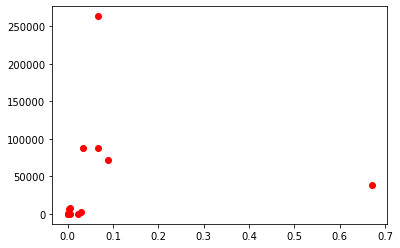

In [231]:
import matplotlib.pyplot as plt
plt.plot(clin_sig_df.score.tolist(), clin_sig_df.counts.tolist(), 'ro')

In [216]:
genetics_df.loc[genetics_df.rsid.isna()]

,chrom,pos,ref,alt,gene_id,study_id,y_proba_full_model,pval_mantissa,pval_exponent,odds_ratio,...,pub_date,pub_author,trait_reported,sample_size,efo,most_severe_csq,csq_arr,most_severe_gene_csq,consequence_link,rsid
391,1,86272676,T,C,ENSG00000171502,NEALE2_5097_raw,0.420986,3.51000,-11,NaN,...,2018-08-01,UKB Neale v2,6mm weak meridian (left),65551,EFO_0007814,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
392,1,86272676,T,C,ENSG00000171502,NEALE2_5099_raw,0.387763,3.14700,-11,NaN,...,2018-08-01,UKB Neale v2,3mm weak meridian (right),75410,EFO_0007814,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
393,1,86272676,T,C,ENSG00000171502,NEALE2_5098_raw,0.452493,2.85420,-11,NaN,...,2018-08-01,UKB Neale v2,6mm weak meridian (right),66256,EFO_0007814,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
394,1,86272676,T,C,ENSG00000171502,NEALE2_5134_raw,0.626174,6.26670,-11,NaN,...,2018-08-01,UKB Neale v2,6mm strong meridian (left),65551,EFO_0007814,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
395,1,86272676,T,C,ENSG00000171502,NEALE2_5132_raw,0.416063,1.43300,-12,NaN,...,2018-08-01,UKB Neale v2,3mm strong meridian (right),75410,EFO_0007814,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931022,8,26385620,A,G,ENSG00000240694,NEALE2_30200_raw,0.036840,1.37214,-9,NaN,...,2018-08-01,UKB Neale v2,Neutrophill percentage,349861,EFO_0007990,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
1931023,8,26385620,A,G,ENSG00000240694,GCST004621,0.037920,8.79500,-19,NaN,...,2016-11-17,Astle WJ,Red cell distribution width,171529,EFO_0005192,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
1931024,8,26385620,A,G,ENSG00000092964,NEALE2_30180_raw,0.046167,2.74443,-9,NaN,...,2018-08-01,UKB Neale v2,Lymphocyte percentage,349861,EFO_0007993,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
1931025,8,26385620,A,G,ENSG00000092964,NEALE2_30200_raw,0.044397,1.37214,-9,NaN,...,2018-08-01,UKB Neale v2,Neutrophill percentage,349861,EFO_0007990,None,None,intergenic_variant,http://purl.obolibrary.org/obo/SO_0001628,None
